In [245]:
import pricing
import model_calibration as model
import options as opt
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from datetime import datetime
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hedging strategy

In [157]:
S0 = 100
K = 100
T = 1
r = 0.04
vol = 0.2
M = 100000

In [163]:
### We start with a simple long call option 
### We buy a call option : we have to sell delta shares of the stock to hedge this option and adujst dynamicaly 
### this position throughout the life of the option

In [164]:
pnl = []
cash_position = []
stocks = []   ### the quantity of underlying stock buyed

### At time t=0

option_price_init = pricing.vanilla_option_price(S0, K, T, r, vol, M, antithetic=True)
delta_init = pricing.get_delta(pricing.vanilla_option_price, S0=S0, K=K, T=T, r=r, vol=vol, M=M, antithetic=True)
asset_price = S0

shares_to_buy = delta_init*asset_price
cash_position.append(-delta_init*asset_price)
stocks.append(shares_to_buy)

### At time t=t
### Suppose it's 10 days after t=0

T2 = T-(10/365)
S = 104   ### Let's assume that the price turned into 104 
delta = pricing.get_delta(pricing.vanilla_option_price, S0=S, K=K, T=T2, r=r, vol=vol, antithetic=True)
shares_to_buy = (delta-delta_init)*S
cash_position.append(shares_to_buy)
stocks.append(delta*S)

In [201]:
asset_prices = pricing.monte_carlo_vectorized(S0=100, T=1, r=0.04, vol=0.2, M=50000, antithetic=True)
asset_prices

,1,2,3,4,5,6,7,8,9,10,...,49991,49992,49993,49994,49995,49996,49997,49998,49999,50000
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,98.649374,101.272502,100.365121,98.127929,99.281562,102.110514,96.996633,99.468972,101.615781,98.921801,...,98.528181,99.110866,99.335358,101.267494,101.605502,100.797002,98.777646,99.180671,100.374870,98.770790
2,100.311449,100.363230,99.428202,97.787820,97.979777,99.593885,95.764108,100.561295,100.925085,99.401300,...,99.612102,97.818076,98.233179,101.126216,101.741604,100.162472,100.267351,99.719399,101.751945,100.646146
3,102.808227,100.888442,102.108217,98.791281,96.376586,98.645300,95.445649,100.779735,102.263911,98.799103,...,98.956348,96.160842,100.059872,101.213025,100.979787,99.363717,100.140070,100.324465,102.549848,99.621779
4,101.384050,98.747575,101.967687,97.800352,97.601045,96.736206,95.004642,98.915478,99.795305,97.915406,...,97.552177,97.048807,101.868961,100.043695,100.688121,99.881966,98.977389,98.878223,99.649186,101.298219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,102.714178,78.562017,113.992821,90.481149,79.433848,93.740413,55.301525,81.598934,112.856492,116.553041,...,101.209048,96.806517,110.824301,73.075759,76.976214,116.323805,91.558417,99.337904,95.619936,112.819565
249,101.051998,78.341337,111.967821,92.867813,81.466003,93.541085,54.204329,80.924845,112.675470,117.052567,...,102.283561,96.691164,111.703136,73.387050,75.671477,117.333433,92.832925,98.911439,93.521098,113.207046
250,99.072665,78.094872,111.233414,94.202297,80.931403,91.658364,54.343281,80.695686,111.508207,117.289804,...,101.624989,96.770274,111.312049,74.241678,76.434673,115.187040,92.956653,96.986983,92.399433,112.645655
251,100.739549,79.239348,110.486873,93.890531,81.108200,91.253088,53.714347,81.346669,113.055674,117.388779,...,101.810392,94.920905,112.178349,73.620074,75.502827,114.980626,91.808125,96.891093,92.205918,112.899619


In [202]:
nbr_adjustments = 5   ### verifier que nbr_adjustments <= len(asset_prices)
adjustments = np.linspace(0, len(asset_prices)-1, nbr_adjustments).astype(int)
adjustments

array([  0,  63, 126, 189, 252])

In [ ]:
prices = asset_prices.loc[adjustments].mean(axis=1)
df = pd.DataFrame(columns=['Asset Prices'], data=prices)
df['Option Price'] = df.apply(lambda row: pricing.vanilla_option_price(S0=row['Asset Prices'], K=K, T=T-float(row.name)/252, r=r, vol=vol, M=M, antithetic=True), axis=1)
#df['BS Prices'] = df.apply(lambda row: opt.black_scholes(r=r, S=row['Asset Prices'], K=K, T=T-float(row.name)/252, sigma=vol), axis=1)
df['Delta'] = df.apply(lambda row: pricing.get_delta(pricing.vanilla_option_price, 
        S0=row['Asset Prices'], K=K, T=T-float(row.name)/252, r=r, vol=vol, M=M, antithetic=True), axis=1)
#df['BS Delta'] = df.apply(lambda row: opt.delta_calc(r=r, S=row['Asset Prices'], K=K, T=T-float(row.name)/252, sigma=vol), axis=1)
df['Shares Value'] = df['Asset Prices']*df['Delta']
df['Cash Position'] = np.where(df.index==0 ,- df['Delta']*df['Asset Prices'], (df['Delta'].shift(1)-df['Delta'])*df['Asset Prices']).cumsum()
df['PnL'] = df['Shares Value'] + df['Cash Position'] - df.iloc[0]['Option Price'] + df['Option Price']

c:\Users\Bouchereau Killian\OneDrive\Bureau\Finance\options_derivatives-1\options.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  d1=(np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Bouchereau Killian\OneDrive\Bureau\Finance\options_derivatives-1\options.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  d1=(np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))


In [227]:
def delta_hedge_option(function, num_hedging_adjustments, long=True, **kwargs):

    ### Les intérêts sur la position en cash sont négligés ici

    S0 = kwargs.get('S0', 100)
    T = kwargs.get('T', 1)
    r = kwargs.get('r', 0.04)
    vol = kwargs.get('vol', 0.2)
    M = kwargs.get('M', 50000)
    antithetic = kwargs.get('antithetic', False)

    new_kwargs = {key: value for key, value in kwargs.items() if key not in ['S0', 'T']}

    if long:
        epsilon = 1
    else:
        epsilon = -1

    asset_prices = pricing.monte_carlo_vectorized(S0=S0, T=T, r=r, vol=vol, M=M, antithetic=antithetic)
    if num_hedging_adjustments > len(asset_prices):
        raise ValueError("The number of dynamic hedging adjustments must be less than or equal to the number of timesteps in the asset price simulation")
    
    hedging_adjustments = np.linspace(0, len(asset_prices)-1, num_hedging_adjustments).astype(int)
    prices = asset_prices.loc[hedging_adjustments].mean(axis=1)
    df = pd.DataFrame(columns=['Asset Prices'], data=prices)
    df['Option Price'] = df.apply(lambda row: function(S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    df['Delta'] = df.apply(lambda row: pricing.get_delta(function, 
            S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    df['Shares Value'] = epsilon*df['Asset Prices']*df['Delta']
    df['Cash Position'] = np.where(df.index==0 , -epsilon*df['Delta']*df['Asset Prices'], epsilon*(df['Delta'].shift(1)-df['Delta'])*df['Asset Prices']).cumsum()
    df['PnL'] = df['Shares Value'] + df['Cash Position'] - epsilon*df.iloc[0]['Option Price'] + epsilon*df['Option Price']
    return df

In [280]:
df = delta_hedge_option(pricing.barrier_option_price, num_hedging_adjustments=100, long=True, S0=100, T=1, K=100, barrier=105, barrier_type="knock_out", r=0.04, vol=0.2, M=10000, opt_type='C', antithetic=True)

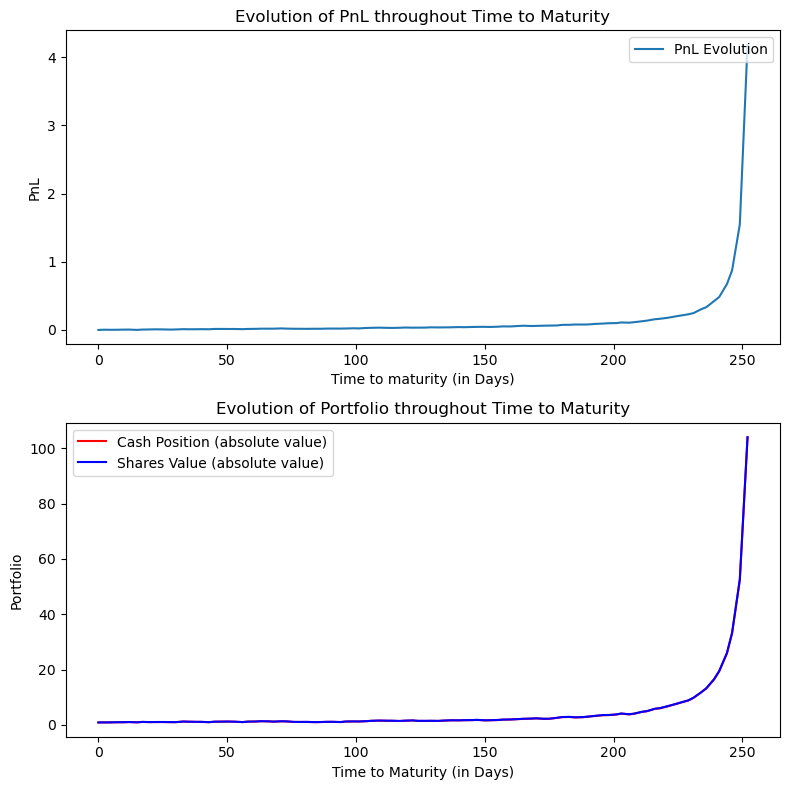

In [283]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['PnL'], label="PnL Evolution")
plt.xlabel('Time to maturity (in Days)')
plt.ylabel("PnL")
plt.title("Evolution of PnL throughout Time to Maturity")
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(df.index, abs(df['Cash Position']), label="Cash Position (absolute value)", color="red")
plt.plot(df.index, abs(df['Shares Value']), label="Shares Value (absolute value)", color="blue")
plt.xlabel('Time to Maturity (in Days)')
plt.ylabel("Portfolio")
plt.title("Evolution of Portfolio throughout Time to Maturity")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

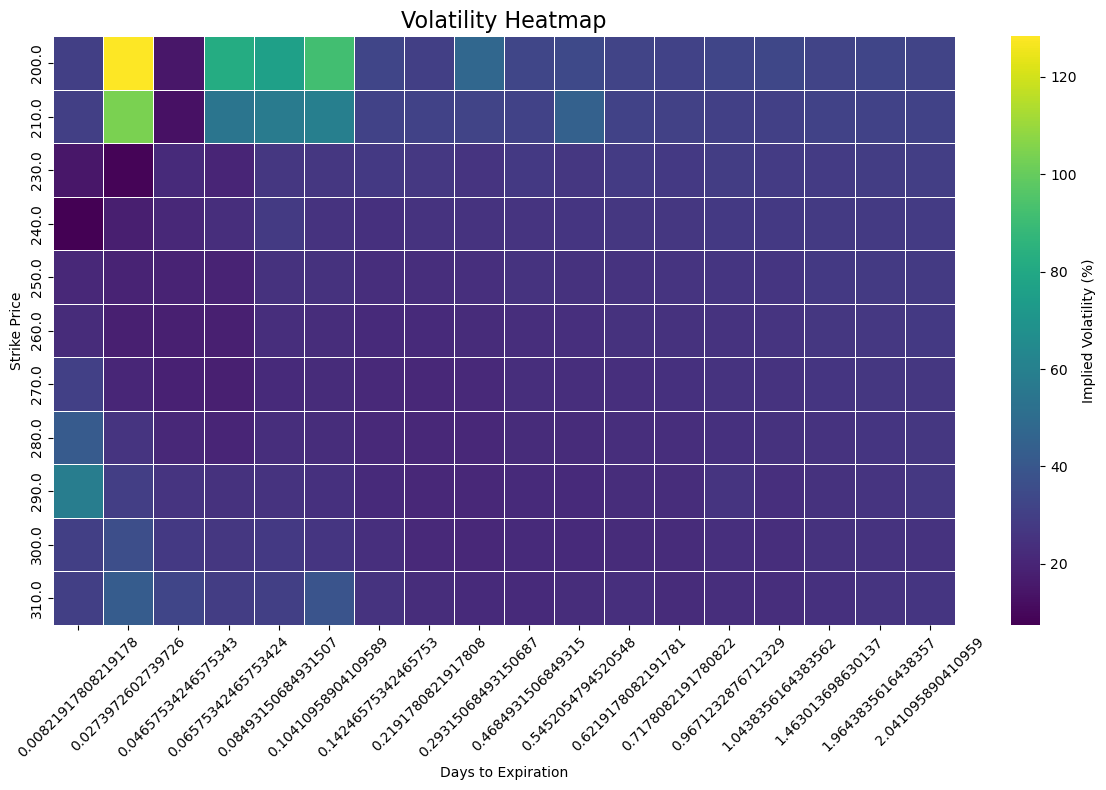

In [300]:
model.plot_volatility_heatmap('AAPL')

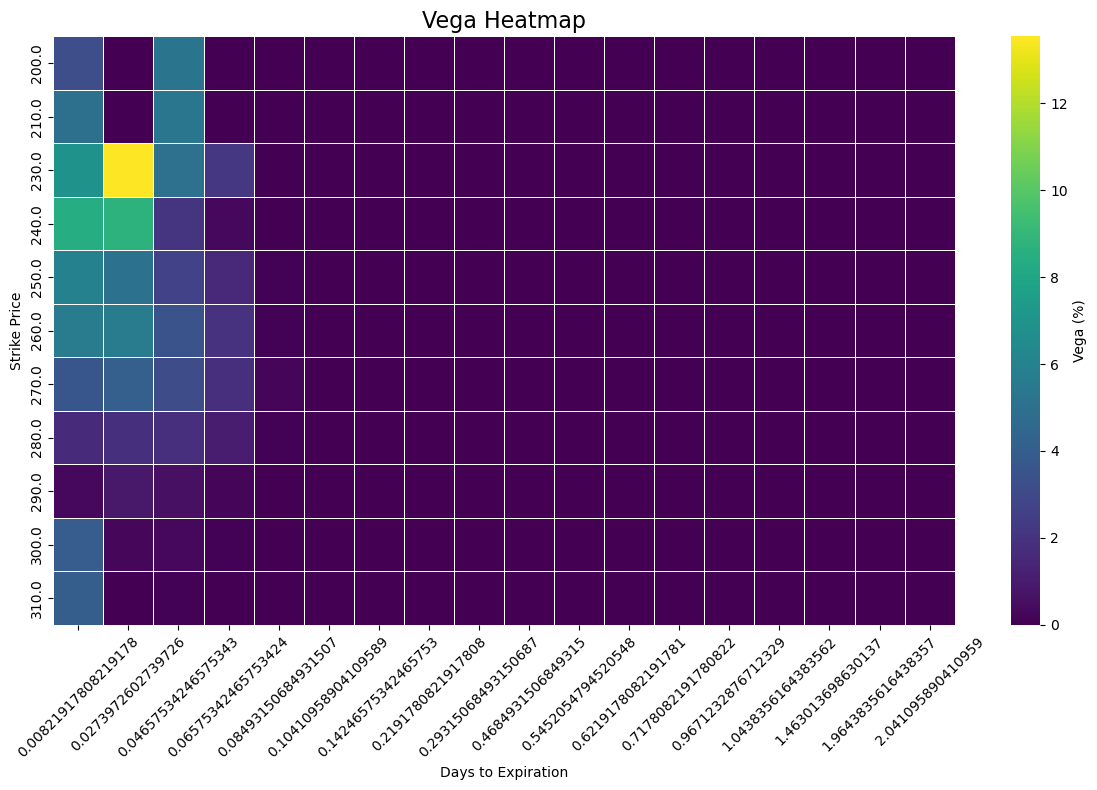

In [301]:
model.plot_vega_heatmap('AAPL')